In [1]:
import sys, h5py, pdb,time, glob
from importlib import reload
import pylab as pl, numpy as np
from numpy import log10 as log, log as ln
from astropy import units as un, constants as cons
import scipy, scipy.stats
from matplotlib import ticker, patches
from mpl_toolkits.mplot3d import Axes3D
sys.path.append('../../pysrc')

In [6]:
import workdirs as wd
import FIRE_files as ff
from FIRE_files import cosmo, u
from projectPlotBasics import *
import first_pass as l
cmap = pl.get_cmap('viridis')
figdir = wd.basedir+'figures/'

In [3]:
CF_path = '../../../cooling_flow/pysrc'
sys.path.append(CF_path)
import cooling_flow as CF, HaloPotential as Halo
%matplotlib inline

In [4]:
(100*un.kpc/un.Gyr).to('km/s')

<Quantity 97.77922217 km / s>

vc200_Rs0_Mdot1212_Rcirc1_fgas02_res1e4_vturb30 144


/mnt/home/jstern/gizmo_analysis/ipynb/subsonic_solution/../../pysrc/FIRE_files.py:1011: RuntimeWarning: invalid value encountered in sqrt
  return (tmp.sum(axis=0)/3.)**0.5
/mnt/home/jstern/gizmo_analysis/ipynb/subsonic_solution/../../pysrc/FIRE_files.py:1013: RuntimeWarning: invalid value encountered in sqrt
  return (self.profile1D('log_nHs',weight,power=2) - self.profile1D('log_nHs',weight)**2)**0.5


vc200_Rs3_Mdot3668_Rcirc1_fgas02_res1e4_vturb30 79


/mnt/home/jstern/gizmo_analysis/ipynb/subsonic_solution/../../pysrc/FIRE_files.py:1010: RuntimeWarning: invalid value encountered in subtract
  tmp=np.array([self.profile1D('v%s'%d,weight,power=2) - self.profile1D('v%s'%d,weight)**2 for d in ('rs','_phi','_theta')])


vc200_Rs20_Mdot4536_Rcirc1_fgas02_res1e4_vturb30 46


/mnt/home/jstern/gizmo_analysis/ipynb/subsonic_solution/../../pysrc/FIRE_files.py:1010: RuntimeWarning: invalid value encountered in subtract
  tmp=np.array([self.profile1D('v%s'%d,weight,power=2) - self.profile1D('v%s'%d,weight)**2 for d in ('rs','_phi','_theta')])
/mnt/home/jstern/gizmo_analysis/ipynb/subsonic_solution/../../pysrc/FIRE_files.py:1011: RuntimeWarning: invalid value encountered in sqrt
  return (tmp.sum(axis=0)/3.)**0.5
/mnt/home/jstern/gizmo_analysis/ipynb/subsonic_solution/../../pysrc/FIRE_files.py:1013: RuntimeWarning: invalid value encountered in sqrt
  return (self.profile1D('log_nHs',weight,power=2) - self.profile1D('log_nHs',weight)**2)**0.5


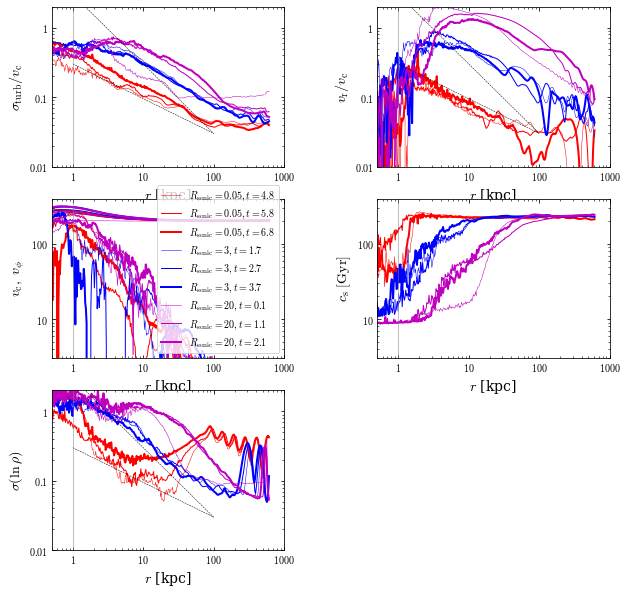

In [7]:
simname_template = 'vc200_Rs%d_Mdot%d_Rcirc1_fgas02_res1e4_vturb30'
vc = 200. *un.km/un.s #float(simname.split('_')[0][2:])
Rcirc = 10.*un.kpc# float(simname.split('_')[3][5:])
pl.figure(figsize=(10,10))
pl.subplots_adjust(wspace=0.4)
ax1,ax2,ax3,ax4,ax5 = [pl.subplot(3,2,i+1) for i in range(5)]
for isim in range(3):
    if isim==0: c,Rsonic,Mdot,snapshots = 'r',0.05,1212,range(95,136,20)
    if isim==1: c,Rsonic,Mdot,snapshots = 'b',3,3668, range(34,75,20)
    if isim==2: c,Rsonic,Mdot,snapshots = 'm',20,4536,range(2,43,20)
    simname = simname_template%(Rsonic,Mdot)
    simdir = '/mnt/home/jstern/Drummond_data/%s/output/'%simname
    sim = l.KY_sim(simname,simdir,200*un.kpc,origin=np.zeros(3),Rcirc = Rcirc,snapshot_dt_Myr=50,pr=False,
              analyticGravity= Halo.PowerLaw(m=0.,vc_Rvir=vc,Rvir=200*un.kpc))
    sim.z = 0 #for cooling function
    print(sim.galaxyname, sim.Nsnapshots())
    for ii,iSnapshot in enumerate(snapshots):
        lw = (0.5,1,2)[ii]
        snapshot = sim.getSnapshot(iSnapshot)
        prof = sim.getProfiler(iSnapshot)
        t = iSnapshot*0.05
        tcool2 = prof.profile1D('cs','MW',power=2)/prof.profile1D('rad_per_unit_mass', 'MW')* ((un.km/un.s)**2/(un.erg/un.s/un.g)).to('Gyr')
        Rcool = prof.rs_midbins()[np.searchsorted(tcool2,t)]
        pl.sca(ax1)
#         pl.axvline(Rcool,c=c,lw=lw)
        pl.loglog(prof.rs_midbins(), prof.sigma_turb() / prof.vc(),c=c,lw=lw)
        pl.sca(ax2)
        pl.loglog(prof.rs_midbins(), prof.t_ff()/2**0.5/prof.t_flow(),c=c,lw=lw)
        pl.sca(ax3)
        pl.loglog(prof.rs_midbins(), prof.vc(),c=c,label=r'$R_{\rm sonic}=%s, t=%.1f$'%(ff.u.nSignificantDigits(Rsonic,1,True),t),lw=lw)
        pl.loglog(prof.rs_midbins(), prof.profile1D('v_phi','MW'),c=c,lw=lw)
        pl.sca(ax4)
        pl.loglog(prof.rs_midbins(), prof.profile1D('cs','MW') ,c=c,lw=lw)
        pl.sca(ax5)
        pl.loglog(prof.rs_midbins(), prof.sigma_log_rho('VW')*ln(10) ,c=c,lw=lw)
        #pl.loglog(prof.rs_midbins(), prof.t_cool(use_actual_temperature=True,useP=False,limit_nH=False)/1000,c=c,lw=0.5)
        #pl.loglog(prof.rs_midbins(), tcool2,c=c,lw=lw)
        prof.tofile()    
for iax,ax in enumerate((ax1,ax2,ax3,ax4,ax5)):
    pl.sca(ax)
    pl.xlim(0.5,1000)
    ax.xaxis.set_major_formatter(u.arilogformatter)
    ax.yaxis.set_major_formatter(u.arilogformatter)
    if iax<2 or iax==4:
        pl.plot([1,100],[3,0.03],lw=0.5,ls='--',c='k')  
        pl.plot([1,100],[0.3,0.03],lw=0.5,ls='--',c='k')        
        pl.ylim(0.01,2)
    else:
        pl.ylim(3,400)
        if iax==2: pl.legend()
    pl.axvline(1.,lw=0.5,c='.5')
    pl.ylabel((r'$\sigma_{\rm turb}/v_{\rm c}$',r'$v_{\rm r}/v_{\rm c}$',
               r'$v_{\rm c},\ v_{\phi}$',r'$c_{\rm s}\ [{\rm Gyr}]$',r'$\sigma (\ln \rho)$')[iax],fontsize=14)
    pl.xlabel(r'$r$ [kpc]',fontsize=14)
pl.savefig(figdir+'turb_analysis.pdf')

(-20.0, 1.0)

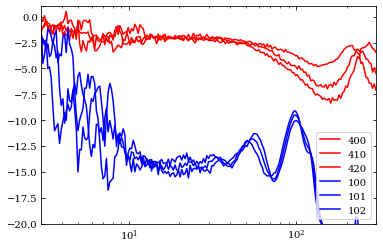

In [40]:
for isim in range(2):
    if isim==0: c,simname,snapshots = 'r','vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4_vturb30',range(400,430,10)
    if isim==1: c,simname,snapshots = 'b', 'vc200_Rs0_Mdot12110_Rcirc10_fgas02_res8e4_vturb30', range(100,103,1)
    simdir = '/mnt/home/jstern/Drummond_data/%s/output/'%simname
    # simname = 'vc200_Rs0_Mdot121_Rcirc10_fgas02_res1e3_vturb30'
    sim = l.KY_sim(simname,simdir,200*un.kpc,origin=np.zeros(3),Rcirc = Rcirc,snapshot_dt_Myr=10,pr=False,
              analyticGravity= Halo.PowerLaw(m=0.,vc_Rvir=vc,Rvir=200*un.kpc))
    sim.z = 0 #for cooling function
    for ii,iSnapshot in enumerate(snapshots):
        snapshot = sim.getSnapshot(iSnapshot)
        prof = sim.getProfiler(iSnapshot)
        pl.semilogx(prof.rs_midbins(), prof.MdotProfile(),c=c,label=iSnapshot)
        prof.tofile()
pl.xlim(3,300)
pl.legend()
pl.ylim(-20,1)

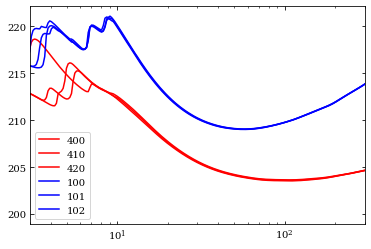

In [41]:
for isim in range(2):
    if isim==0: c,simname,snapshots = 'r','vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4_vturb30',range(400,430,10)
    if isim==1: c,simname,snapshots = 'b', 'vc200_Rs0_Mdot12110_Rcirc10_fgas02_res8e4_vturb30', range(100,103,1)
    simdir = '/mnt/home/jstern/Drummond_data/%s/output/'%simname
    # simname = 'vc200_Rs0_Mdot121_Rcirc10_fgas02_res1e3_vturb30'
    sim = l.KY_sim(simname,simdir,200*un.kpc,origin=np.zeros(3),Rcirc = Rcirc,snapshot_dt_Myr=10,pr=False,
              analyticGravity= Halo.PowerLaw(m=0.,vc_Rvir=vc,Rvir=200*un.kpc))
    sim.z = 0 #for cooling function
    for ii,iSnapshot in enumerate(snapshots):
        snapshot = sim.getSnapshot(iSnapshot)
        prof = sim.getProfiler(iSnapshot)
        pl.semilogx(prof.rs_midbins(), prof.vc(),c=c,label=iSnapshot)
        prof.tofile()
pl.xlim(3,300)
pl.legend()


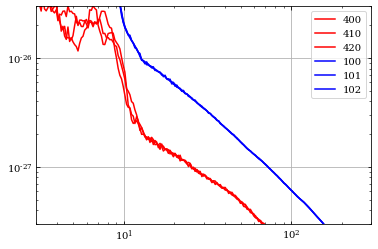

In [44]:
for isim in range(2):
    if isim==0: c,simname,snapshots = 'r','vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4_vturb30',range(400,430,10)
    if isim==1: c,simname,snapshots = 'b', 'vc200_Rs0_Mdot12110_Rcirc10_fgas02_res8e4_vturb30', range(100,103,1)
    simdir = '/mnt/home/jstern/Drummond_data/%s/output/'%simname
    # simname = 'vc200_Rs0_Mdot121_Rcirc10_fgas02_res1e3_vturb30'
    sim = l.KY_sim(simname,simdir,200*un.kpc,origin=np.zeros(3),Rcirc = Rcirc,snapshot_dt_Myr=10,pr=False,
              analyticGravity= Halo.PowerLaw(m=0.,vc_Rvir=vc,Rvir=200*un.kpc))
    sim.z = 0 #for cooling function
    for ii,iSnapshot in enumerate(snapshots):
        snapshot = sim.getSnapshot(iSnapshot)
        prof = sim.getProfiler(iSnapshot)
        pl.loglog(prof.rs_midbins(), prof.rhoProfile(),c=c,label=iSnapshot)
        prof.tofile()
pl.xlim(3,300)
pl.ylim(0.3e-27,0.3e-25)
pl.legend()
pl.grid()

/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:894: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]
/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:894: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]
/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:894: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs_MW
saved vrs_MW
saved vrs_MW


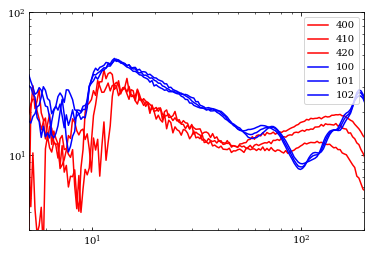

In [37]:
for isim in range(2):
    if isim==0: c,simname,snapshots = 'r','vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4_vturb30',range(400,430,10)
    if isim==1: c,simname,snapshots = 'b', 'vc200_Rs0_Mdot12110_Rcirc10_fgas02_res8e4_vturb30', range(100,103,1)
    simdir = '/mnt/home/jstern/Drummond_data/%s/output/'%simname
    # simname = 'vc200_Rs0_Mdot121_Rcirc10_fgas02_res1e3_vturb30'
    sim = l.KY_sim(simname,simdir,200*un.kpc,origin=np.zeros(3),Rcirc = Rcirc,snapshot_dt_Myr=10,pr=False,
              analyticGravity= Halo.PowerLaw(m=0.,vc_Rvir=vc,Rvir=200*un.kpc))
    sim.z = 0 #for cooling function
    for ii,iSnapshot in enumerate(snapshots):
        snapshot = sim.getSnapshot(iSnapshot)
        prof = sim.getProfiler(iSnapshot)
        pl.loglog(prof.rs_midbins(), -prof.profile1D('vrs','MW'),c=c,label=iSnapshot)
        prof.tofile()
    pl.xlim(5,200)
    pl.ylim(3,100)
    pl.legend()

/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs_MW
saved vrs_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs_MW
saved vrs_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs_MW
saved vrs_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


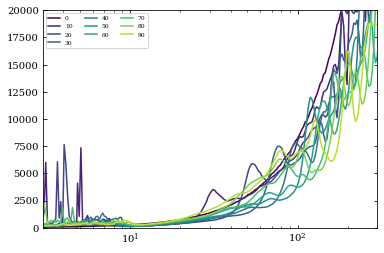

In [19]:
for ii,iSnapshot in enumerate(range(0,100,10)):
    c = pl.get_cmap('viridis')(ii/10)
    snapshot = sim.getSnapshot(iSnapshot)
    prof = sim.getProfiler(iSnapshot)
    pl.semilogx(prof.rs_midbins(), prof.t_flow(),c=c,label=iSnapshot)
pl.xlim(3,300)
pl.ylim(0,20e3)
pl.legend(fontsize=6,ncol=3)

/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs2_MW
saved vrs_MW
saved v_phi2_MW
saved v_phi_MW
saved v_theta2_MW
saved v_theta_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:1030: RuntimeWarning: invalid value encountered in sqrt
  return (tmp.sum(axis=0)/3.)**0.5


saved massProfile0
saved massProfile2
saved massProfile4


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs2_MW
saved vrs_MW
saved v_phi2_MW
saved v_phi_MW
saved v_theta2_MW
saved v_theta_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:1030: RuntimeWarning: invalid value encountered in sqrt
  return (tmp.sum(axis=0)/3.)**0.5


saved massProfile0
saved massProfile2
saved massProfile4


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs2_MW
saved vrs_MW
saved v_phi2_MW
saved v_phi_MW
saved v_theta2_MW
saved v_theta_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:1030: RuntimeWarning: invalid value encountered in sqrt
  return (tmp.sum(axis=0)/3.)**0.5


saved massProfile0
saved massProfile2
saved massProfile4


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs2_MW
saved vrs_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:360: RuntimeWarning: divide by zero encountered in true_divide
  return j_z / (self.rs()*self.sin_theta(z_vec))


saved v_phi2_MW
saved v_phi_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:1029: RuntimeWarning: invalid value encountered in subtract
  tmp=np.array([self.profile1D('v%s'%d,weight,power=2) - self.profile1D('v%s'%d,weight)**2 for d in ('rs','_phi','_theta')])
/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:366: RuntimeWarning: invalid value encountered in multiply
  vtheta2 *= vtheta2>0 #avoid nans


saved v_theta2_MW
saved v_theta_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:1030: RuntimeWarning: invalid value encountered in sqrt
  return (tmp.sum(axis=0)/3.)**0.5


saved massProfile0
saved massProfile2
saved massProfile4


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs2_MW
saved vrs_MW
saved v_phi2_MW
saved v_phi_MW
saved v_theta2_MW
saved v_theta_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:1030: RuntimeWarning: invalid value encountered in sqrt
  return (tmp.sum(axis=0)/3.)**0.5


saved massProfile0
saved massProfile2
saved massProfile4


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs2_MW
saved vrs_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:360: RuntimeWarning: divide by zero encountered in true_divide
  return j_z / (self.rs()*self.sin_theta(z_vec))


saved v_phi2_MW
saved v_phi_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:1029: RuntimeWarning: invalid value encountered in subtract
  tmp=np.array([self.profile1D('v%s'%d,weight,power=2) - self.profile1D('v%s'%d,weight)**2 for d in ('rs','_phi','_theta')])
/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:366: RuntimeWarning: invalid value encountered in multiply
  vtheta2 *= vtheta2>0 #avoid nans


saved v_theta2_MW
saved v_theta_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:1030: RuntimeWarning: invalid value encountered in sqrt
  return (tmp.sum(axis=0)/3.)**0.5


saved massProfile0
saved massProfile2
saved massProfile4


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs2_MW
saved vrs_MW
saved v_phi2_MW
saved v_phi_MW
saved v_theta2_MW
saved v_theta_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:1030: RuntimeWarning: invalid value encountered in sqrt
  return (tmp.sum(axis=0)/3.)**0.5


saved massProfile0
saved massProfile2
saved massProfile4


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs2_MW
saved vrs_MW
saved v_phi2_MW
saved v_phi_MW
saved v_theta2_MW
saved v_theta_MW
saved massProfile0
saved massProfile2
saved massProfile4


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs2_MW
saved vrs_MW
saved v_phi2_MW
saved v_phi_MW
saved v_theta2_MW
saved v_theta_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:1030: RuntimeWarning: invalid value encountered in sqrt
  return (tmp.sum(axis=0)/3.)**0.5


saved massProfile0
saved massProfile2
saved massProfile4


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs2_MW
saved vrs_MW
saved v_phi2_MW
saved v_phi_MW
saved v_theta2_MW
saved v_theta_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:1030: RuntimeWarning: invalid value encountered in sqrt
  return (tmp.sum(axis=0)/3.)**0.5


saved massProfile0
saved massProfile2
saved massProfile4


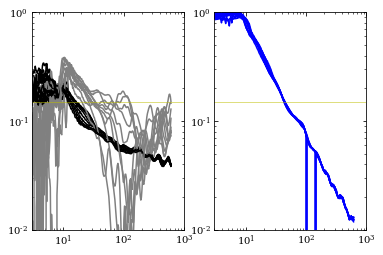